In [1]:
import os
import copy
import random
import collections
import itertools
import numpy as np
import pandas as pd
import warnings
from sklearn.externals import joblib
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [2]:
# Count the frequency of k-mer in each RNA sequence
#k-mer was normalized by total k-mer count of each RNA sequence
def _count_kmer(Dataset,k): # k = 3,4,5
    
    # copy dataset
    dataset = copy.deepcopy(Dataset)
    # alphbet of nucleotide
    nucleotide = ['A','C','G','T']
    
    # generate k-mers

    #  k == 5:
    five = list(itertools.product(nucleotide,repeat=5))
    pentamer = []
    for n in five:
        pentamer.append("".join(n))
    
    #  k == 4:
    four = list(itertools.product(nucleotide,repeat=4))
    tetramer = []
    for n in four:
        tetramer.append("".join(n))

    # k == 3:
    three = list(itertools.product(nucleotide,repeat=3))
    threemer = []
    for n in three:
        threemer.append("".join(n))
    
    # input features can be combinations of diffrent k values
    if k == 34:
        table_kmer = dict.fromkeys(threemer,0)
        table_kmer.update(dict.fromkeys(tetramer,0))
    if k == 45:
        table_kmer = dict.fromkeys(tetramer,0)
        table_kmer.update(dict.fromkeys(pentamer,0))
    if k == 345:
        table_kmer = dict.fromkeys(threemer,0)
        table_kmer.update(dict.fromkeys(tetramer,0))
        table_kmer.update(dict.fromkeys(pentamer,0))

    # count k-mer for each sequence
    for mer in table_kmer.keys():
        table_kmer[mer] = dataset["cdna"].apply(lambda x : x.count(mer))

    # for k-mer raw count without normalization, index: nuc:1 or cyto:0
    rawcount_kmer_df = pd.DataFrame(table_kmer)
    df1_rawcount = pd.concat([rawcount_kmer_df,dataset["ensembl_transcript_id"]],axis = 1)
    df1_rawcount.index = dataset["tag"]

    # for k-mer frequency with normalization , index: nuc:1 or cyto:0
    freq_kmer_df = rawcount_kmer_df.apply(lambda x: x/x.sum(),axis=1)
    df1 = pd.concat([freq_kmer_df,dataset["ensembl_transcript_id"]],axis = 1)
    df1.index = dataset["tag"]

    return df1,df1_rawcount

In [3]:
#Evaluate performance of model
def evaluate_performance(y_test, y_pred, y_prob):
    # AUROC
    auroc = metrics.roc_auc_score(y_test,y_prob)
    auroc_curve = metrics.roc_curve(y_test, y_prob)
    # AUPRC
    auprc=metrics.average_precision_score(y_test, y_prob) 
    auprc_curve=metrics.precision_recall_curve(y_test, y_prob)
    #Accuracy
    accuracy=metrics.accuracy_score(y_test,y_pred) 
    #MCC
    mcc=metrics.matthews_corrcoef(y_test,y_pred)
    
    recall=metrics.recall_score(y_test, y_pred)
    precision=metrics.precision_score(y_test, y_pred)
    f1=metrics.f1_score(y_test, y_pred)
    class_report=metrics.classification_report(y_test, y_pred,target_names = ["control","case"])

    model_perf = {"auroc":auroc,"auroc_curve":auroc_curve,
                  "auprc":auprc,"auprc_curve":auprc_curve,
                  "accuracy":accuracy, "mcc": mcc,
                  "recall":recall,"precision":precision,"f1":f1,
                  "class_report":class_report}
        
    return model_perf

In [4]:
# Output result of evaluation
def eval_output(model_perf,path):
    with open(os.path.join(path,"Evaluate_Result_TestSet.txt"),'w') as f:
        f.write("AUROC=%s\tAUPRC=%s\tAccuracy=%s\tMCC=%s\tRecall=%s\tPrecision=%s\tf1_score=%s\n" %
               (model_perf["auroc"],model_perf["auprc"],model_perf["accuracy"],model_perf["mcc"],model_perf["recall"],model_perf["precision"],model_perf["f1"]))
        f.write("\n######NOTE#######\n")
        f.write("#According to help_documentation of sklearn.metrics.classification_report:in binary classification, recall of the positive class is also known as sensitivity; recall of the negative class is specificity#\n\n")
        f.write(model_perf["class_report"])

In [5]:
# Plot AUROC of model
def plot_AUROC(model_perf,path):
    #get AUROC,FPR,TPR and threshold
    roc_auc = model_perf["auroc"]
    fpr,tpr,threshold = model_perf["auroc_curve"]
    #return AUROC info
    temp_df = pd.DataFrame({"FPR":fpr,"TPR":tpr})
    temp_df.to_csv(os.path.join(path,"AUROC_info.txt"),header = True,index = False, sep = '\t')
    #plot
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='AUROC (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUROC of Models")
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(path,"AUROC_TestSet.pdf"),format = "pdf")

In [6]:
warnings.filterwarnings(action='ignore')

# Output dir
output_dir = "Evaluation_Result"
if not (os.path.exists(output_dir)):
    os.mkdir(output_dir)

<Figure size 432x288 with 0 Axes>

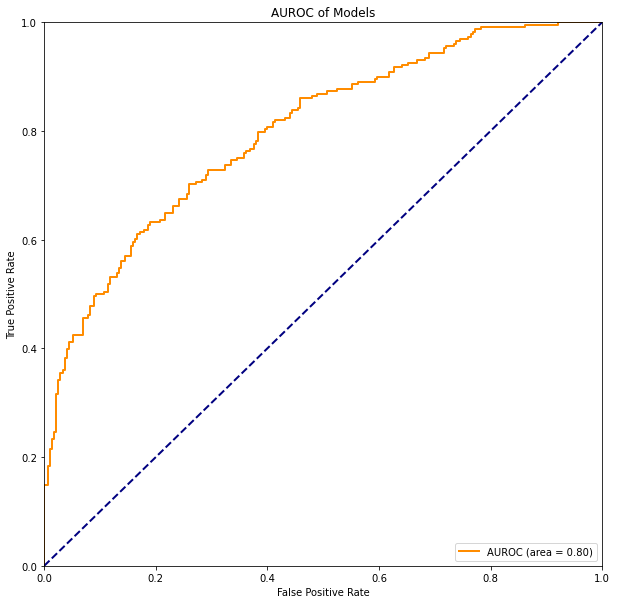

In [7]:
# Load test data set
TestSet = pd.read_csv("../../03_Model_Construction/mRNA_sublocation_TestSet.tsv",sep = '\t')
TestSet_df_kmer_345,TestSet_df_kmer_345_rawcount = _count_kmer(TestSet,345)

del TestSet_df_kmer_345['ensembl_transcript_id']

# Load LncLight model
lgb_best_model = joblib.load("../../03_Model_Construction/01_Machine_Learning_Model/01_ML_Model_Output/LightGBM/best_LightGBM_model.pkl")

# Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = lgb_best_model.predict(TestSet_df_kmer_345)
y_prob = lgb_best_model.predict_proba(TestSet_df_kmer_345)[:,1]

# Evaluate model performance
model_perf = evaluate_performance(np.array(TestSet_df_kmer_345.index),y_pred,y_prob)
eval_output(model_perf,output_dir)
plot_AUROC(model_perf,output_dir)

# Add predict label
TestSet["predict_label"] = y_pred
TestSet.to_csv(os.path.join(output_dir,"mRNA_sublocation_TestSet_RNA-Light_predict.tsv"),sep = '\t',index = False)